# Temperature calculated by DTS interrogator

In [80]:
import os
import glob
import h5py
import numpy as np
import pandas as pd
import matplotlib
from obspy import UTCDateTime
from das_util import get_tstamp_dts, calc_NFFT
from matplotlib import pyplot as plt
%matplotlib inline
matplotlib.rcParams.update({'font.size': 12})

## Step 1- Merge segemented files and Quality control

In [2]:
# %% sort and merge files
data_dir = '/data/whd01/qibin_data/England_DTS/DTS_England_channel1'
file_list = np.array(sorted(glob.glob(data_dir+'/England_Bugs_distributed_data*.csv')))
df_list = []

# %% continuous time after 10th file based on manual check 
for fname in file_list[10:]:
    df = pd.read_csv(fname, low_memory=False)
    ds = pd.to_numeric(df['Unnamed: 0'], errors='coerce')
    df = df.loc[(ds > 0) & (ds < 150)]
    df.drop(df.columns[df.columns.str.contains('unnamed',case=False)], axis=1, inplace=True)
    df_list.append(df)
df = pd.concat(df_list, axis=1)

df.to_csv(data_dir + '/merged_temperature.csv', sep=',', index=False)

In [58]:
# %% only run this cell after the previous one has been executed
df = pd.read_csv(data_dir + '/merged_temperature.csv', low_memory=False)

In [59]:
df

,2023/03/17 18:25:47,2023/03/17 18:26:09,2023/03/17 18:26:31,2023/03/17 18:26:53,2023/03/17 18:27:15,2023/03/17 18:27:37,2023/03/17 18:27:59,2023/03/17 18:28:21,2023/03/17 18:28:42,2023/03/17 18:29:04,...,2023/03/19 10:13:41,2023/03/19 10:14:03,2023/03/19 10:14:25,2023/03/19 10:14:47,2023/03/19 10:15:09,2023/03/19 10:15:31,2023/03/19 10:15:53,2023/03/19 10:16:15,2023/03/19 10:16:37,2023/03/19 10:16:59
0,22.271,22.295,22.353,22.346,22.366,22.380,22.345,22.344,22.484,22.486,...,19.554,19.544,19.558,19.540,19.616,19.549,19.666,19.506,19.696,19.608
1,20.267,20.390,20.406,20.378,20.443,20.353,20.367,20.373,20.527,20.490,...,16.156,16.112,16.161,16.147,16.134,16.091,16.228,15.947,16.168,16.176
2,16.935,17.154,17.177,17.150,17.250,17.044,17.105,17.086,17.222,17.173,...,11.901,11.871,11.892,11.881,11.845,11.893,11.838,11.759,11.997,12.003
3,14.938,15.011,15.093,15.118,15.142,14.988,15.031,14.946,15.138,15.125,...,9.505,9.544,9.502,9.433,9.432,9.435,9.422,9.452,9.681,9.647
4,14.431,14.372,14.419,14.504,14.397,14.432,14.404,14.373,14.501,14.554,...,8.819,8.974,8.876,8.748,8.733,8.776,8.863,8.857,8.929,9.024
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
585,10.259,10.310,10.287,10.220,10.320,10.254,10.178,10.174,10.104,10.192,...,8.501,8.540,8.634,8.540,8.611,8.587,8.472,8.336,8.429,8.637
586,10.249,10.246,10.161,10.251,10.256,10.199,10.100,10.136,10.107,10.161,...,8.514,8.563,8.586,8.447,8.411,8.424,8.453,8.425,8.332,8.516
587,10.248,10.309,10.140,10.315,10.253,10.182,10.118,10.204,10.132,10.275,...,8.574,8.643,8.652,8.538,8.420,8.319,8.546,8.484,8.327,8.506
588,10.218,10.456,10.280,10.310,10.332,10.217,10.196,10.251,10.199,10.378,...,8.616,8.607,8.678,8.616,8.581,8.326,8.538,8.433,8.428,8.530


[UTCDateTime(2023, 3, 17, 18, 25, 47) UTCDateTime(2023, 3, 17, 18, 26, 9)
 UTCDateTime(2023, 3, 17, 18, 26, 31) ...
 UTCDateTime(2023, 3, 19, 10, 16, 15) UTCDateTime(2023, 3, 19, 10, 16, 37)
 UTCDateTime(2023, 3, 19, 10, 16, 59)]


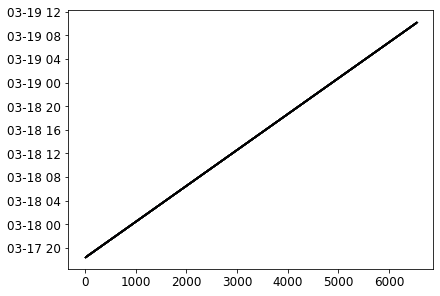

In [60]:
# check if the time of measurements is continous (linear)
time_labels = df.keys().to_numpy()
start_time = np.array([get_tstamp_dts(i) for i in time_labels])
print(start_time)
plt.close('all')
fig, ax = plt.subplots(1, 1, figsize=(6,4), constrained_layout=True)
ax.scatter(np.arange(len(start_time)), start_time.astype('datetime64[s]'), marker='o', s=0.1, edgecolors='k')

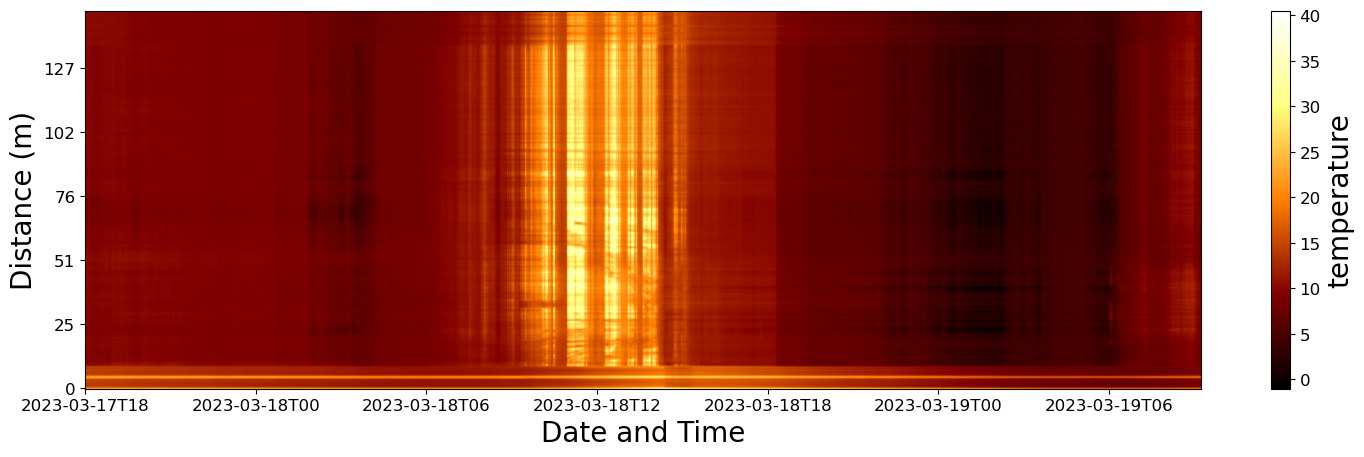

In [207]:
# %% visualize the temperature in time-space
channel_space = 0.254

plt.close('all')
plt.figure(figsize = (18, 5), dpi = 100)
plt.imshow(df.values, cmap='afmhot', aspect='auto', origin='lower')

plt.ylabel("Distance (m)", fontsize = 20)
plt.xlabel("Date and Time", fontsize = 20)
plt.xticks(np.arange(0, df.shape[1], 1000), 
           start_time[0: df.shape[1]: 1000].astype('datetime64[h]'))
plt.yticks(np.arange(0, df.shape[0], 100), 
           np.rint(np.arange(0, df.shape[0], 100) * channel_space).astype(int))
cbr = plt.colorbar()
cbr.set_label('temperature', fontsize = 20)

## Step 2- Get the data for a time window

In [61]:
def get_dts(channel, starttime, endtime):
    df = pd.read_csv(data_dir + '/merged_temperature.csv', low_memory=False)
    time_labels = df.keys().to_numpy()
    start_time = np.array([get_tstamp_dts(i) for i in time_labels])
    
    time_idx = np.where(np.logical_and(start_time<endtime, start_time>starttime))[0]

    return df.iloc[channel, time_idx], start_time[time_idx]

Text(0.5, 0, 'Date and Time')

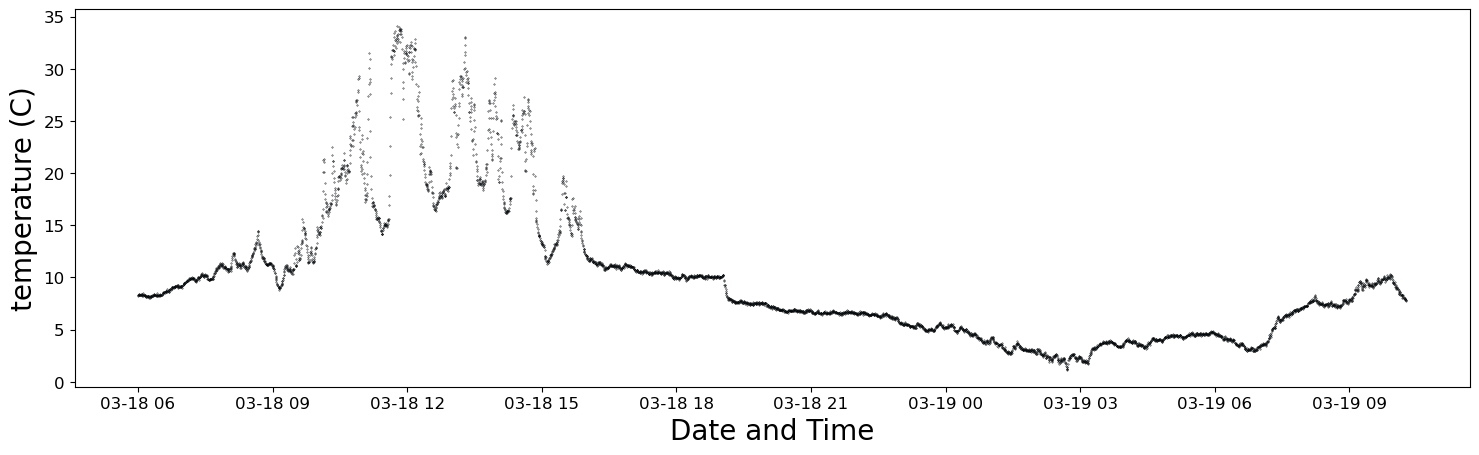

In [120]:
temp_window, time_window = get_dts(channel=300, 
                                   starttime=UTCDateTime(2023, 3, 18, 6, 0, 0), 
                                   endtime=UTCDateTime(2023, 3, 19, 15, 0, 0))

plt.close('all')
plt.figure(figsize = (18, 5), dpi = 100)
plt.scatter(time_window.astype('datetime64[m]'), temp_window, marker='o', s=0.1, edgecolors='k')
plt.ylabel("temperature (C)", fontsize = 20)
plt.xlabel("Date and Time", fontsize = 20)

## Step 3- Compare with the DAS data

In [81]:
# %% read DAS
datah5 = '/data/whd01/qibin_data/farmDAS_harper_0_24hr.hdf5'
with h5py.File(datah5, 'r') as f:
    full_time_data_h5 = f["data"][:]
    sample_rate_h5 = f["dt"][()]
    time_stamp_h5 = f["timestamp"][:]

sample_rate = sample_rate_h5
acqu_time = np.array([UTCDateTime(i) for i in time_stamp_h5])


NFFT=8192 samples, equivalent to 81.92 seconds
saturated for period > 40.96 seconds


In [132]:
# %% read DTS
df = pd.read_csv(data_dir + '/merged_temperature.csv', low_memory=False)
start_time = np.array([get_tstamp_dts(i) for i in df.keys().to_numpy()])
time_idx = np.where(start_time<acqu_time[0]+36*3600)[0]

df = df.iloc[:, time_idx]

temp_window, time_window = get_dts(channel=416, 
                                   starttime=start_time[0], 
                                   endtime=acqu_time[0]+36*3600)


In [106]:
start_ch, end_ch = 44, 94            # channel range
ch_id = 33                           # choose a channel to visualize
start_minutes = 0                    # starting file indice for reading
num_minutes = 2160                    # number of semi-continuous 1-min files to merge
num_seconds = int(num_minutes * 60)  # total duration (s) of merged time series
dsamp_factor = 20                    # downsample rate when reading raw time series
sample_rate = int(2000 / dsamp_factor)    # final sample rate after downsampling
shift_min = 7                        # shift in minutes of the first tick when ploting
shift_sec = int(shift_min * 60)      # shift in seconds
file_inc = 360                       # plot ticks for every {file_inc} 1-min files 
time_inc = int(file_inc * 60)        # tick interval in seconds

In [128]:
time_diff = int((start_time[0]-acqu_time[0])/60)
full_time_data = full_time_data_h5[:, time_diff:]

NFFT=8192 samples, equivalent to 81.92 seconds
saturated for period > 40.96 seconds
(819, 1807) (819,) (1807,)
(2047, 1807) (2047,) (1807,)


Text(0.5, 0, 'time ')

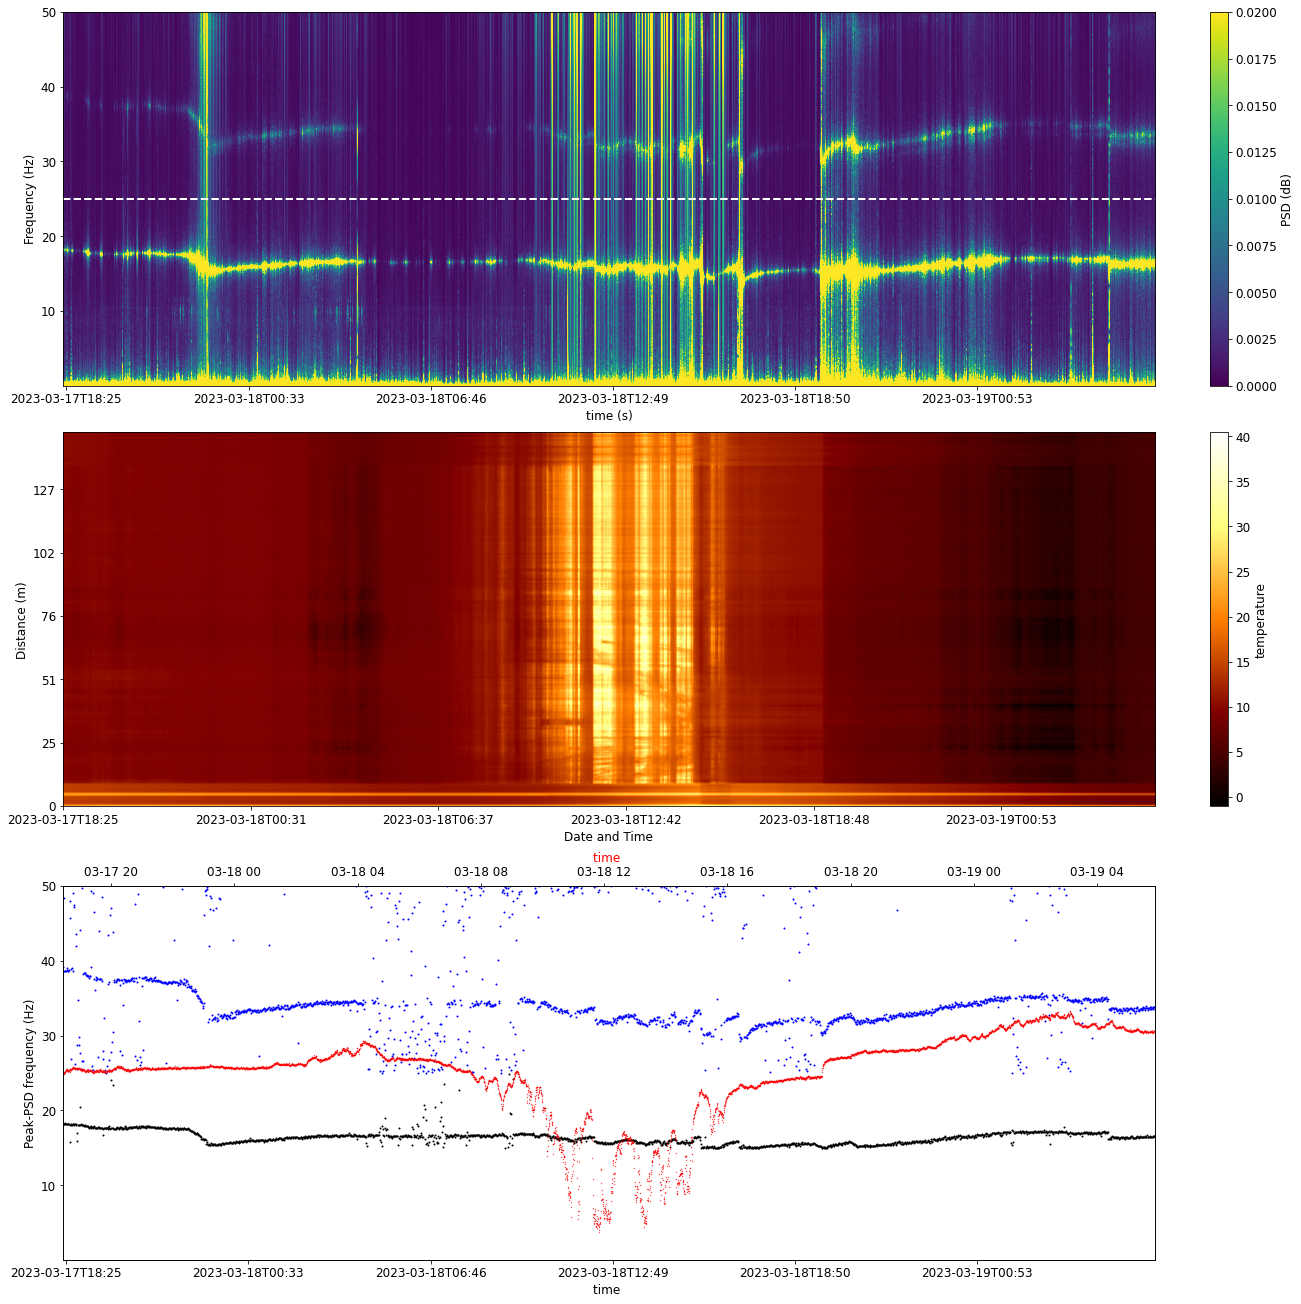

In [145]:
# %% calculate the best NFFT for plotting
nfft, time_width = calc_NFFT(full_time_data[33], sample_rate, power_of_2=True)
print(f'saturated for period > {time_width/2} seconds')
# %% plot data in time-frequency
plt.close('all')
fig, ax = plt.subplots(3, 1, figsize=(18, 18), constrained_layout=True)
Pxx,freqs,bins,image=ax[0].specgram(full_time_data[ch_id],Fs=sample_rate,
                                    mode='magnitude',NFFT=nfft,noverlap=int(nfft/8), 
                                    scale='linear', vmin=0, vmax=0.02)
hline = ax[0].axhline(25, linestyle='--', linewidth=2, color='w') 
cbr = fig.colorbar(image, ax=ax[0])
cbr.set_label('PSD (dB)', fontsize = 12)

# ax[0].set_yscale("log")
ax[0].set_ylim(2/time_width, sample_rate/2)
ax[0].set_xlabel("time (s)", fontsize = 12)
ax[0].set_ylabel("Frequency (Hz)", fontsize = 12)

# %% set up time ticks for every 20 minutes (20 1-min files)
ax[0].set_xticks(np.arange(0+shift_sec, num_seconds, time_inc))
ax[0].set_xticklabels(time_diff+acqu_time[start_minutes:start_minutes+num_minutes:file_inc].astype('datetime64[m]'))


# %% 1st mode resonance of every time bin
ind = np.where(np.logical_and(freqs > 15, freqs < 25))[0]
Pxx1 = Pxx[ind, :]
freqs1 = freqs[ind]
# %% 2nd mode resonance of every time bin
ind = np.where(np.logical_and(freqs > 25, freqs < 50))[0]
Pxx2 = Pxx[ind, :]
freqs2 = freqs[ind]

freq_ind1 = np.argmax(Pxx1, axis=0)
freq_ind2 = np.argmax(Pxx2, axis=0)
print(Pxx1.shape, freqs1.shape, freq_ind1.shape)
print(Pxx2.shape, freqs2.shape, freq_ind2.shape)

ax[2].scatter(bins, freqs1[freq_ind1], marker='o', s=1, edgecolors='k')
ax[2].scatter(bins, freqs2[freq_ind2], marker='o', s=1, edgecolors='b')
ax[2].set_ylim(2/time_width, sample_rate/2)
ax[2].set_xlim(bins[0], bins[-1])
ax[2].set_xlabel("time ", fontsize = 12)
ax[2].set_ylabel("Peak-PSD frequency (Hz)", fontsize = 12)
ax[2].set_xticks(np.arange(0+shift_sec, num_seconds, time_inc))
ax[2].set_xticklabels(time_diff+acqu_time[start_minutes:start_minutes+num_minutes:file_inc].astype('datetime64[m]'))

# %% visualize the temperature in time-space
channel_space = 0.254

image = ax[1].imshow(df.values, cmap='afmhot', aspect='auto', origin='lower')

ax[1].set_ylabel("Distance (m)", fontsize = 12)
ax[1].set_xlabel("Date and Time", fontsize = 12)
ax[1].set_xticks(np.arange(0, df.shape[1], 1000))
ax[1].set_xticklabels(start_time[0: df.shape[1]: 1000].astype('datetime64[m]'))
ax[1].set_yticks(np.arange(0, df.shape[0], 100)) 
ax[1].set_yticklabels(np.rint(np.arange(0, df.shape[0], 100) * channel_space).astype(int))
cbr = fig.colorbar(image, ax=ax[1])
cbr.set_label('temperature', fontsize = 12)

axcopy = ax[2].twiny()
axcopy.scatter(time_window.astype('datetime64[s]'), 35-temp_window, marker='o', s=0.1, edgecolors='r')
axcopy.set_xlim(start_time[0], acqu_time[0]+36*3600)
axcopy.set_xlabel("time ", fontsize = 12, color='r')